# Exploratory Data Analysis

#### Importing Necessary Libraries

In [12]:
import seaborn as sns
import math as math
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.preprocessing.sequence import TimeseriesGenerator

### Functions For EDA

#### Function for cleaning up -999 when rides are closed

In [13]:
def CleanNegatives(df,Tag,CleanName):
    InBlock = False  # Tags that I am inside of a -999 block
    Start = 0
    End   = 0
    Clean = df[Tag]
    for Index in range(len(Clean)):
        if InBlock:
            if Clean[Index] > 0: # Exit condition 
                End = Index
                InBlock = False
                AVG = (Clean[Start-1]+Clean[End])/2
                # Cleaning negatives, replacing by average at the endpoints of the block
                for NewIndex in range(Start,End):
                    Clean[NewIndex] = AVG
        else:  # Not In the block
            if Clean[Index] < 0: # Enter condition
                Start = Index
                InBlock = True
    df[CleanName] = Clean
                

#### Function for merging columns

In [14]:
def Cleanup(df,Tag1,Tag2,ResultTag):
    Clean = []
    for i in range(len(df)):
        Value = ( df[Tag1][i] if not math.isnan(df[Tag1][i]) else df[Tag2][i])
        Clean.append(Value)
    df[ResultTag] = Clean

#### Function to test stationairy

In [15]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value', '#Lags Used',
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

## MAGIC KINGDOM

### 7 Dwarfs Mine Train

In [16]:
df_mk_7dwarfs = pd.read_csv("data/7_dwarfs_train.csv")
df_mk_7dwarfs

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0
...,...,...,...,...
321626,12/28/2021,2021-12-28 22:42:15,NaN,45.0
321627,12/28/2021,2021-12-28 22:48:12,NaN,45.0
321628,12/28/2021,2021-12-28 22:54:10,NaN,45.0
321629,12/28/2021,2021-12-28 22:54:28,10.0,NaN


#### Cleaning up data: Removing -999. Taking average of day before and after

In [17]:
CleanNegatives(df_mk_7dwarfs,'SPOSTMIN','SPOSTMINClean')
print(df_mk_7dwarfs)

<ipython-input-13-778444a50a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


              date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0       01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0
1       01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0
2       01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN
3       01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0
4       01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0
...            ...                  ...      ...       ...            ...
321626  12/28/2021  2021-12-28 22:42:15      NaN      45.0           45.0
321627  12/28/2021  2021-12-28 22:48:12      NaN      45.0           45.0
321628  12/28/2021  2021-12-28 22:54:10      NaN      45.0           45.0
321629  12/28/2021  2021-12-28 22:54:28     10.0       NaN            NaN
321630  12/28/2021  2021-12-28 22:57:34      NaN      35.0           35.0

[321631 rows x 5 columns]


#### Merging columns

In [18]:
Cleanup(df_mk_7dwarfs,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_mk_7dwarfs)

              date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0       01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0   
1       01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0   
2       01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN   
3       01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0   
4       01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0   
...            ...                  ...      ...       ...            ...   
321626  12/28/2021  2021-12-28 22:42:15      NaN      45.0           45.0   
321627  12/28/2021  2021-12-28 22:48:12      NaN      45.0           45.0   
321628  12/28/2021  2021-12-28 22:54:10      NaN      45.0           45.0   
321629  12/28/2021  2021-12-28 22:54:28     10.0       NaN            NaN   
321630  12/28/2021  2021-12-28 22:57:34      NaN      35.0           35.0   

        CleanTime  
0            45.0  
1            60.0  
2            54

In [19]:
df_mk_7dwarfs[df_mk_7dwarfs.CleanTime < 0]

,date,datetime,SACTMIN,SPOSTMIN,SPOSTMINClean,CleanTime
105109,02/20/2017,2017-02-20 09:04:37,-92918.0,NaN,NaN,-92918.0


In [20]:
df_mk_7dwarfs = df_mk_7dwarfs[df_mk_7dwarfs['CleanTime'] >= 0]

In [21]:
df_mk_7dwarfs[df_mk_7dwarfs.CleanTime < 0]

,date,datetime,SACTMIN,SPOSTMIN,SPOSTMINClean,CleanTime


In [22]:
df_mk_7dwarfs

,date,datetime,SACTMIN,SPOSTMIN,SPOSTMINClean,CleanTime
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0,45.0,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0,60.0,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN,NaN,54.0
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0,60.0,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0,60.0,60.0
...,...,...,...,...,...,...
321626,12/28/2021,2021-12-28 22:42:15,NaN,45.0,45.0,45.0
321627,12/28/2021,2021-12-28 22:48:12,NaN,45.0,45.0,45.0
321628,12/28/2021,2021-12-28 22:54:10,NaN,45.0,45.0,45.0
321629,12/28/2021,2021-12-28 22:54:28,10.0,NaN,NaN,10.0


In [23]:
# df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN == -999] = np.nan


In [24]:
df_mk_7dwarfs['datetime'] = pd.to_datetime(df_mk_7dwarfs.datetime)
df_mk_7dwarfs.set_index('datetime', inplace=True)


<ipython-input-24-6e5af379a8a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mk_7dwarfs['datetime'] = pd.to_datetime(df_mk_7dwarfs.datetime)


In [25]:
df_mk_7dwarfs = df_mk_7dwarfs['CleanTime']

In [26]:
df_mk_7dwarfs

datetime
2015-01-01 07:51:12    45.0
2015-01-01 08:02:13    60.0
2015-01-01 08:05:30    54.0
2015-01-01 08:09:12    60.0
2015-01-01 08:16:12    60.0
                       ... 
2021-12-28 22:42:15    45.0
2021-12-28 22:48:12    45.0
2021-12-28 22:54:10    45.0
2021-12-28 22:54:28    10.0
2021-12-28 22:57:34    35.0
Name: CleanTime, Length: 321524, dtype: float64

In [27]:
df_mk_7dwarfs.isna().sum()

0

In [28]:
df_mk_7dwarfs_daily = df_mk_7dwarfs.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

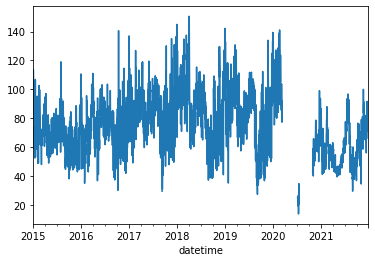

In [29]:
df_mk_7dwarfs_daily.plot()

In [30]:
df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [31]:
df_mk_7dwarfs_daily 

datetime
2015-01-02    112.993421
2015-01-03    100.469697
2015-01-04     79.685039
2015-01-05     87.370690
2015-01-06     79.066667
                 ...    
2019-12-27     91.559441
2019-12-28     88.639286
2019-12-29     93.121429
2019-12-30    116.776978
2019-12-31    133.416149
Freq: D, Name: CleanTime, Length: 1825, dtype: float64

In [32]:
df_mk_7dwarfs_daily[df_mk_7dwarfs_daily.isna()]

datetime
2017-09-10   NaN
2017-09-11   NaN
Freq: D, Name: CleanTime, dtype: float64

In [33]:
# df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.ffill()[(df_mk_7dwarfs_daily.index > '2017-09-10') & (df_mk_7dwarfs_daily.index < '2017-09-11')


In [34]:
df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.ffill()

In [35]:
df_mk_7dwarfs_daily

datetime
2015-01-02    112.993421
2015-01-03    100.469697
2015-01-04     79.685039
2015-01-05     87.370690
2015-01-06     79.066667
                 ...    
2019-12-27     91.559441
2019-12-28     88.639286
2019-12-29     93.121429
2019-12-30    116.776978
2019-12-31    133.416149
Freq: D, Name: CleanTime, Length: 1825, dtype: float64

In [36]:
df_mk_7dwarfs_daily[df_mk_7dwarfs_daily.isna()]

Series([], Freq: D, Name: CleanTime, dtype: float64)

In [37]:
# df_mk_7dwarfs = df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN != -999]
# df_mk_7dwarfs

<AxesSubplot:xlabel='datetime'>

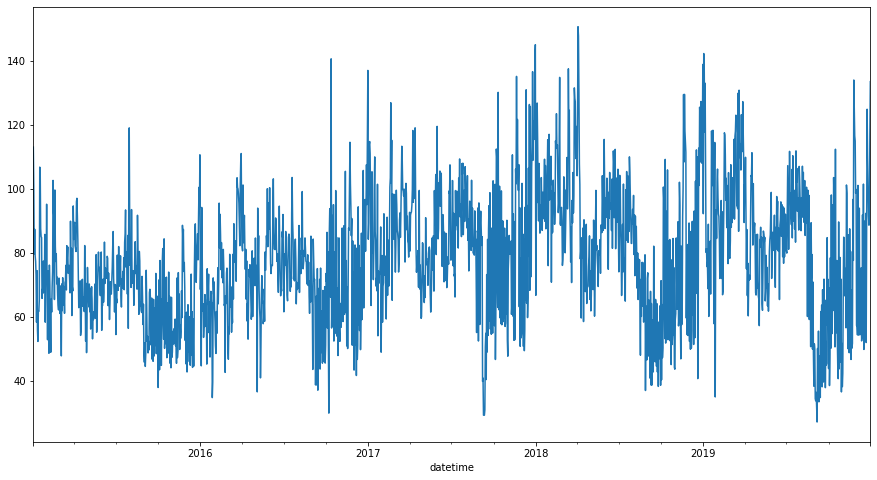

In [38]:
df_mk_7dwarfs_daily.plot(figsize=(15,8))

In [39]:
# df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN == -999] = "NaN"

In [40]:
pvalue = adfuller(df_mk_7dwarfs_daily)[1]
is_stationary = pvalue<= .05

is_stationary

True

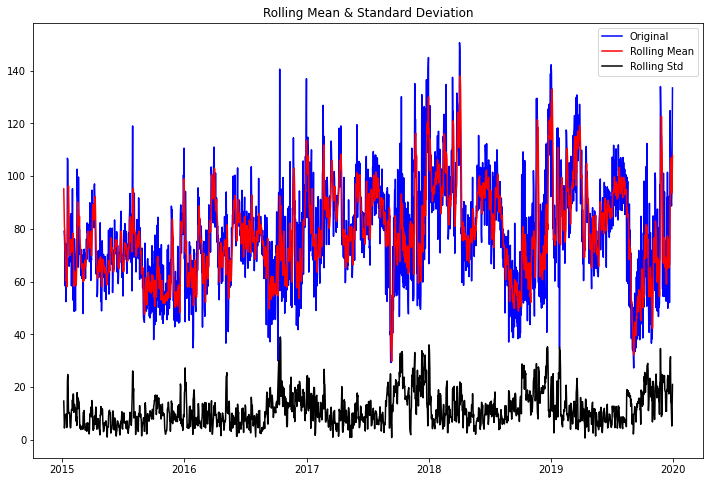

Results of Dickey-Fuller Test:
Test Statistic                   -5.171053
p-value                           0.000010
#Lags Used                       21.000000
Number of Observations Used    1803.000000
Critical Value (1%)              -3.433982
Critical Value (5%)              -2.863144
Critical Value (10%)             -2.567624
dtype: float64


In [41]:
test_stationarity(df_mk_7dwarfs_daily, 4)

In [42]:
df_mk_7dwarfs_daily.shape

(1825,)

#### Finding the index which allows us to split off 20% of the data

In [43]:
cutoff = round(df_mk_7dwarfs_daily.shape[0]*0.8)
cutoff

1460

#### Define train and test sets according to the index found above

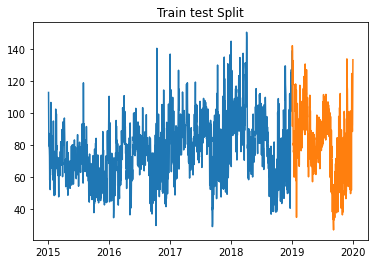

In [44]:
train = df_mk_7dwarfs_daily[:cutoff]
test = df_mk_7dwarfs_daily[cutoff:]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

### Random Walk Model

In [45]:
df_mk_7dwarfs_daily_random_walk = train.shift(1)
df_mk_7dwarfs_daily_random_walk

datetime
2015-01-02           NaN
2015-01-03    112.993421
2015-01-04    100.469697
2015-01-05     79.685039
2015-01-06     87.370690
                 ...    
2018-12-27    108.372159
2018-12-28    127.233533
2018-12-29    125.554913
2018-12-30    107.985876
2018-12-31    116.238764
Freq: D, Name: CleanTime, Length: 1460, dtype: float64

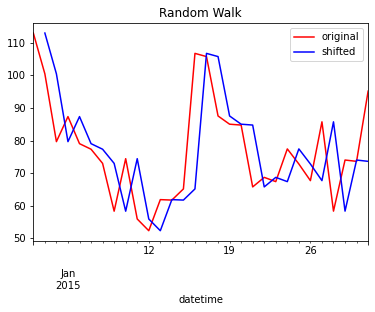

In [46]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
df_mk_7dwarfs_daily_random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [47]:
np.sqrt(mean_squared_error(train[1:], df_mk_7dwarfs_daily_random_walk.dropna()))

18.683201111595267

In [48]:
residuals = df_mk_7dwarfs_daily_random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

18.683201111595267

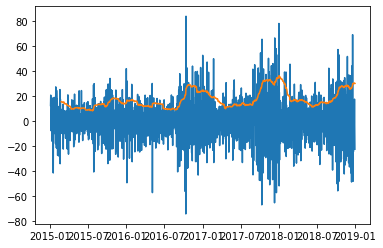

In [49]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

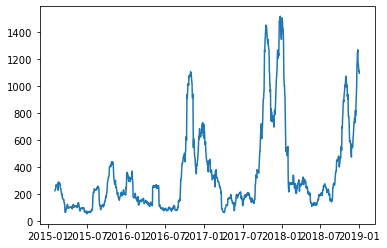

In [50]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

### ARIMA Model

In [51]:
df_mk_7dwarfs_daily_arima = ARIMA(train, order=(3,1,3)).fit()


In [52]:
df_mk_7dwarfs_daily_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CleanTime   No. Observations:                 1460
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5885.895
Date:                Mon, 28 Feb 2022   AIC                          11785.790
Time:                        13:47:57   BIC                          11822.788
Sample:                    01-02-2015   HQIC                         11799.592
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5631      0.036    -43.097      0.000      -1.634      -1.492
ar.L2         -0.5812      0.063     -9.203      0.000      -0.705      -0.457
ar.L3          0.2242      0.034      6.599      0.000       0.158       0.291
ma.L1          0.9349      0.028     32.914      0.000       0.879       0.991
ma.L2         -0.4241      0.038    -11.206      0.000      -0.498      -0.350
ma.L3         -0.7087      0.021    -33.159      0.000      -0.751      -0.667
sigma2       186.5846      5.379     34.690      0.000     176.043     197.126
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               203.00
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
print("AIC - ARIMA Model:", df_mk_7dwarfs_daily_arima.aic)


AIC - ARIMA Model: 11785.789605808015


#### PACF

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


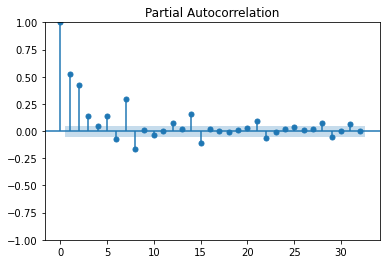

In [54]:
plot_pacf(train);

#### ACF

In [55]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
datetime,,
2015-01-02,112.993421,NaN
2015-01-03,100.469697,112.993421
2015-01-04,79.685039,100.469697
2015-01-05,87.370690,79.685039
2015-01-06,79.066667,87.370690


In [56]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

194.99013413810863

In [57]:
#Pearson Correlation
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.5276849513620424

In [58]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.527685,0.584016,0.485603,0.444830,0.466850
lag_1,0.527685,1.000000,0.525831,0.583067,0.482827,0.441686
lag_2,0.584016,0.525831,1.000000,0.524808,0.581649,0.480995
lag_3,0.485603,0.583067,0.524808,1.000000,0.523642,0.580648
lag_4,0.444830,0.482827,0.581649,0.523642,1.000000,0.521481
lag_5,0.466850,0.441686,0.480995,0.580648,0.521481,1.000000


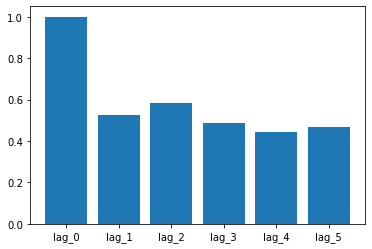

In [59]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

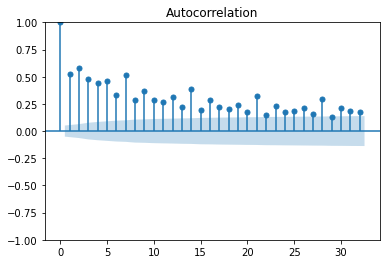

In [60]:
plot_acf(train);

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


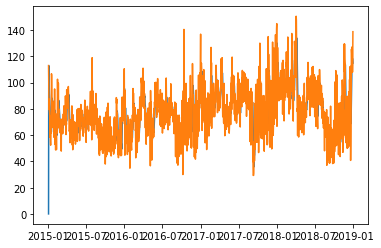

In [61]:
df_mk_7dwarfs_daily_arima2 = ARIMA(train, order=(1, 1, 2)).fit()
y_hat_train = df_mk_7dwarfs_daily_arima2.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

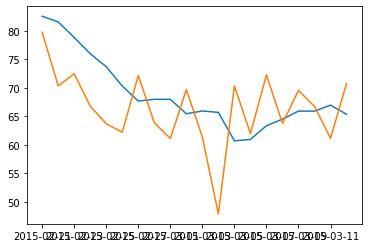

In [62]:
fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [63]:
df_mk_7dwarfs_daily_arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CleanTime   No. Observations:                 1460
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5997.738
Date:                Mon, 28 Feb 2022   AIC                          12003.477
Time:                        13:48:02   BIC                          12024.619
Sample:                    01-02-2015   HQIC                         12011.364
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4633      0.156     -2.972      0.003      -0.769      -0.158
ma.L1         -0.3108      0.159     -1.949      0.051      -0.623       0.002
ma.L2         -0.2253      0.121     -1.857      0.063      -0.463       0.012
sigma2       217.7599      6.594     33.025      0.000     204.836     230.684
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                80.94
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

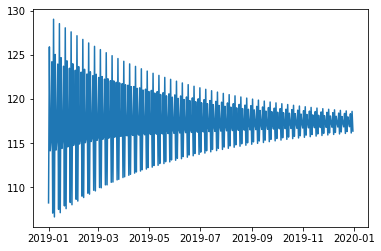

In [64]:
y_hat_test = df_mk_7dwarfs_daily_arima.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(y_hat_test);

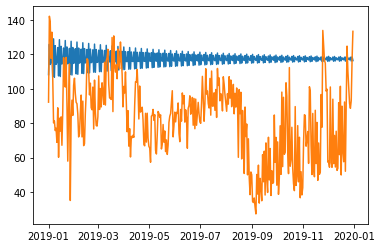

In [65]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test);

In [66]:
np.sqrt(mean_squared_error(test, y_hat_test))

41.73915635912372

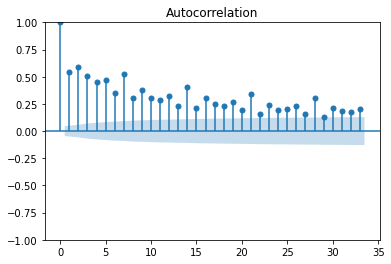

In [67]:
plot_acf(df_mk_7dwarfs_daily);

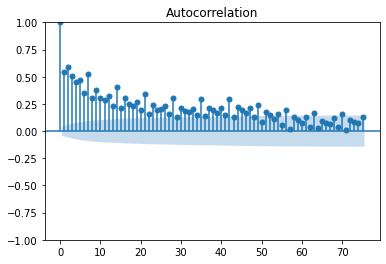

In [68]:
plot_acf(df_mk_7dwarfs_daily, lags=75);

In [69]:
p = q = range(0, 5)
pdq = list(itertools.product(p, [0], q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 0) x (0, 1, 0, 7)
SARIMAX: (0, 0, 0) x (0, 1, 1, 7)
SARIMAX: (0, 0, 0) x (0, 1, 2, 7)
SARIMAX: (0, 0, 0) x (0, 1, 3, 7)
SARIMAX: (0, 0, 0) x (0, 1, 4, 7)
SARIMAX: (0, 0, 0) x (1, 1, 0, 7)
SARIMAX: (0, 0, 0) x (1, 1, 1, 7)
SARIMAX: (0, 0, 0) x (1, 1, 2, 7)
SARIMAX: (0, 0, 0) x (1, 1, 3, 7)
SARIMAX: (0, 0, 0) x (1, 1, 4, 7)
SARIMAX: (0, 0, 0) x (2, 1, 0, 7)
SARIMAX: (0, 0, 0) x (2, 1, 1, 7)
SARIMAX: (0, 0, 0) x (2, 1, 2, 7)
SARIMAX: (0, 0, 0) x (2, 1, 3, 7)
SARIMAX: (0, 0, 0) x (2, 1, 4, 7)
SARIMAX: (0, 0, 0) x (3, 1, 0, 7)
SARIMAX: (0, 0, 0) x (3, 1, 1, 7)
SARIMAX: (0, 0, 0) x (3, 1, 2, 7)
SARIMAX: (0, 0, 0) x (3, 1, 3, 7)
SARIMAX: (0, 0, 0) x (3, 1, 4, 7)
SARIMAX: (0, 0, 0) x (4, 1, 0, 7)
SARIMAX: (0, 0, 0) x (4, 1, 1, 7)
SARIMAX: (0, 0, 0) x (4, 1, 2, 7)
SARIMAX: (0, 0, 0) x (4, 1, 3, 7)
SARIMAX: (0, 0, 0) x (4, 1, 4, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 0, 1) x (0, 1, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 2, 7)
SARIMAX: (0,

In [ ]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:12625.09984925855
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:12183.529184428899
ARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC:12081.189278850172
ARIMA(0, 0, 0)x(0, 1, 3, 7) - AIC:12021.214250209761
ARIMA(0, 0, 0)x(0, 1, 4, 7) - AIC:11961.274847876652
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:12367.1997554394
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:12141.643039204962
ARIMA(0, 0, 0)x(1, 1, 2, 7) - AIC:12068.860113281404
ARIMA(0, 0, 0)x(1, 1, 3, 7) - AIC:12022.508827050144
ARIMA(0, 0, 0)x(1, 1, 4, 7) - AIC:11960.766757012632
ARIMA(0, 0, 0)x(2, 1, 0, 7) - AIC:12237.678500607863
ARIMA(0, 0, 0)x(2, 1, 1, 7) - AIC:12082.960589540344
ARIMA(0, 0, 0)x(2, 1, 2, 7) - AIC:12077.198364957749
ARIMA(0, 0, 0)x(2, 1, 3, 7) - AIC:12015.841702334892
Oops!
ARIMA(0, 0, 0)x(3, 1, 0, 7) - AIC:12134.742617866908
ARIMA(0, 0, 0)x(3, 1, 1, 7) - AIC:12025.267758444028
ARIMA(0, 0, 0)x(3, 1, 2, 7) - AIC:12025.149718674751
Oops!
ARIMA(0, 0, 0)x(3, 1, 4, 7) - AIC:11956.816004334078
ARIMA(0, 0, 0)x(4, 1, 0, 7) - AIC:120

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(4, 1, 3, 7) - AIC:11967.248517921777


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(4, 1, 4, 7) - AIC:11958.692320764618
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:12414.901357367715
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:11908.210466926497
ARIMA(0, 0, 1)x(0, 1, 2, 7) - AIC:11824.353796625746
ARIMA(0, 0, 1)x(0, 1, 3, 7) - AIC:11766.391615265307
ARIMA(0, 0, 1)x(0, 1, 4, 7) - AIC:11709.854459958166
ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:12131.388901173836
ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:11880.617674357696
ARIMA(0, 0, 1)x(1, 1, 2, 7) - AIC:11814.193423326156
ARIMA(0, 0, 1)x(1, 1, 3, 7) - AIC:11768.381136214852
ARIMA(0, 0, 1)x(1, 1, 4, 7) - AIC:11710.362811753916
ARIMA(0, 0, 1)x(2, 1, 0, 7) - AIC:11997.402226812554
ARIMA(0, 0, 1)x(2, 1, 1, 7) - AIC:11837.564026660919
ARIMA(0, 0, 1)x(2, 1, 2, 7) - AIC:11823.583801157773
ARIMA(0, 0, 1)x(2, 1, 3, 7) - AIC:11763.285210704113
ARIMA(0, 0, 1)x(2, 1, 4, 7) - AIC:11710.150719207657
ARIMA(0, 0, 1)x(3, 1, 0, 7) - AIC:11893.278053120071
ARIMA(0, 0, 1)x(3, 1, 1, 7) - AIC:11780.648407724699
ARIMA(0, 0, 1)x(3, 1, 2, 7) - AIC:11782.071063

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(4, 1, 3, 7) - AIC:11723.783586626141
ARIMA(0, 0, 1)x(4, 1, 4, 7) - AIC:11711.955145706863
ARIMA(0, 0, 2)x(0, 1, 0, 7) - AIC:12321.559389946276
ARIMA(0, 0, 2)x(0, 1, 1, 7) - AIC:11751.252585521026
ARIMA(0, 0, 2)x(0, 1, 2, 7) - AIC:11679.11141103646
ARIMA(0, 0, 2)x(0, 1, 3, 7) - AIC:11624.539871356461
ARIMA(0, 0, 2)x(0, 1, 4, 7) - AIC:11571.243858525511
ARIMA(0, 0, 2)x(1, 1, 0, 7) - AIC:12021.739135977425
ARIMA(0, 0, 2)x(1, 1, 1, 7) - AIC:11734.244537179722
ARIMA(0, 0, 2)x(1, 1, 2, 7) - AIC:11671.177856303719
ARIMA(0, 0, 2)x(1, 1, 3, 7) - AIC:11626.452800133247
ARIMA(0, 0, 2)x(1, 1, 4, 7) - AIC:11571.0538638758
ARIMA(0, 0, 2)x(2, 1, 0, 7) - AIC:11874.713682227717
ARIMA(0, 0, 2)x(2, 1, 1, 7) - AIC:11706.985925033063
ARIMA(0, 0, 2)x(2, 1, 2, 7) - AIC:11680.843281409263
ARIMA(0, 0, 2)x(2, 1, 3, 7) - AIC:11628.04999161416
ARIMA(0, 0, 2)x(2, 1, 4, 7) - AIC:11571.541970533803
ARIMA(0, 0, 2)x(3, 1, 0, 7) - AIC:11761.945072544853
ARIMA(0, 0, 2)x(3, 1, 1, 7) - AIC:11646.7029964343

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(3, 1, 3, 7) - AIC:11620.204447933935
ARIMA(0, 0, 2)x(3, 1, 4, 7) - AIC:11571.79364994451
ARIMA(0, 0, 2)x(4, 1, 0, 7) - AIC:11653.115935327205
ARIMA(0, 0, 2)x(4, 1, 1, 7) - AIC:11590.766700704316
ARIMA(0, 0, 2)x(4, 1, 2, 7) - AIC:11592.641540556671


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(4, 1, 3, 7) - AIC:11588.495479609144


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(4, 1, 4, 7) - AIC:11573.735488179638
ARIMA(0, 0, 3)x(0, 1, 0, 7) - AIC:12282.442460919285
ARIMA(0, 0, 3)x(0, 1, 1, 7) - AIC:11679.95777841414
ARIMA(0, 0, 3)x(0, 1, 2, 7) - AIC:11616.94861856274
ARIMA(0, 0, 3)x(0, 1, 3, 7) - AIC:11562.361889117787
ARIMA(0, 0, 3)x(0, 1, 4, 7) - AIC:11510.617536938296
ARIMA(0, 0, 3)x(1, 1, 0, 7) - AIC:11976.429412769598
ARIMA(0, 0, 3)x(1, 1, 1, 7) - AIC:11669.3273557209
ARIMA(0, 0, 3)x(1, 1, 2, 7) - AIC:11618.007957838054
ARIMA(0, 0, 3)x(1, 1, 3, 7) - AIC:11564.137063453953
ARIMA(0, 0, 3)x(1, 1, 4, 7) - AIC:11511.37390753937
ARIMA(0, 0, 3)x(2, 1, 0, 7) - AIC:11820.217912487635
ARIMA(0, 0, 3)x(2, 1, 1, 7) - AIC:11652.252784495595
ARIMA(0, 0, 3)x(2, 1, 2, 7) - AIC:11618.93157732944
ARIMA(0, 0, 3)x(2, 1, 3, 7) - AIC:11566.131662262887
ARIMA(0, 0, 3)x(2, 1, 4, 7) - AIC:11511.199075302738
ARIMA(0, 0, 3)x(3, 1, 0, 7) - AIC:11711.807554712444
ARIMA(0, 0, 3)x(3, 1, 1, 7) - AIC:11591.43788492307
ARIMA(0, 0, 3)x(3, 1, 2, 7) - AIC:11593.13725204506


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(3, 1, 3, 7) - AIC:11557.756755217768
ARIMA(0, 0, 3)x(3, 1, 4, 7) - AIC:11511.576625845004
ARIMA(0, 0, 3)x(4, 1, 0, 7) - AIC:11604.407930328565
ARIMA(0, 0, 3)x(4, 1, 1, 7) - AIC:11535.235362273705
ARIMA(0, 0, 3)x(4, 1, 2, 7) - AIC:11537.019152428536


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 1, 3, 7) - AIC:11534.448645724393


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 1, 4, 7) - AIC:11513.494991078765
ARIMA(0, 0, 4)x(0, 1, 0, 7) - AIC:12209.771920414425
ARIMA(0, 0, 4)x(0, 1, 1, 7) - AIC:11637.398230849332
ARIMA(0, 0, 4)x(0, 1, 2, 7) - AIC:11577.204249929291
ARIMA(0, 0, 4)x(0, 1, 3, 7) - AIC:11521.143675468988
ARIMA(0, 0, 4)x(0, 1, 4, 7) - AIC:11468.266301770665
ARIMA(0, 0, 4)x(1, 1, 0, 7) - AIC:11941.48522690672
ARIMA(0, 0, 4)x(1, 1, 1, 7) - AIC:11628.756005984933
ARIMA(0, 0, 4)x(1, 1, 2, 7) - AIC:11564.713007692346
ARIMA(0, 0, 4)x(1, 1, 3, 7) - AIC:11523.12653259073
ARIMA(0, 0, 4)x(1, 1, 4, 7) - AIC:11470.087770636148
ARIMA(0, 0, 4)x(2, 1, 0, 7) - AIC:11785.766500290756
ARIMA(0, 0, 4)x(2, 1, 1, 7) - AIC:11616.404284810178
ARIMA(0, 0, 4)x(2, 1, 2, 7) - AIC:11577.56994115575


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 4)x(2, 1, 3, 7) - AIC:11510.809413892806
ARIMA(0, 0, 4)x(2, 1, 4, 7) - AIC:11470.86848979261
ARIMA(0, 0, 4)x(3, 1, 0, 7) - AIC:11677.954562433199
ARIMA(0, 0, 4)x(3, 1, 1, 7) - AIC:11555.82772746739
ARIMA(0, 0, 4)x(3, 1, 2, 7) - AIC:11557.52259562834
ARIMA(0, 0, 4)x(3, 1, 3, 7) - AIC:11512.498788466959
ARIMA(0, 0, 4)x(3, 1, 4, 7) - AIC:11472.105598876662
ARIMA(0, 0, 4)x(4, 1, 0, 7) - AIC:11575.28167751271
ARIMA(0, 0, 4)x(4, 1, 1, 7) - AIC:11499.74541179143
ARIMA(0, 0, 4)x(4, 1, 2, 7) - AIC:11501.831540126419


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 4)x(4, 1, 3, 7) - AIC:11499.033188507645


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 4)x(4, 1, 4, 7) - AIC:11460.939056604726
ARIMA(1, 0, 0)x(0, 1, 0, 7) - AIC:12327.090256417972
ARIMA(1, 0, 0)x(0, 1, 1, 7) - AIC:11731.155791714096
ARIMA(1, 0, 0)x(0, 1, 2, 7) - AIC:11665.603096799952
ARIMA(1, 0, 0)x(0, 1, 3, 7) - AIC:11611.249842456906
ARIMA(1, 0, 0)x(0, 1, 4, 7) - AIC:11558.429219646072
ARIMA(1, 0, 0)x(1, 1, 0, 7) - AIC:11985.921752491939
ARIMA(1, 0, 0)x(1, 1, 1, 7) - AIC:11721.928368986913
ARIMA(1, 0, 0)x(1, 1, 2, 7) - AIC:11666.181535513191
ARIMA(1, 0, 0)x(1, 1, 3, 7) - AIC:11613.044742751761
ARIMA(1, 0, 0)x(1, 1, 4, 7) - AIC:11558.288008090873
ARIMA(1, 0, 0)x(2, 1, 0, 7) - AIC:11836.755736597312
ARIMA(1, 0, 0)x(2, 1, 1, 7) - AIC:11666.094139643026
ARIMA(1, 0, 0)x(2, 1, 2, 7) - AIC:11667.802526602758
ARIMA(1, 0, 0)x(2, 1, 3, 7) - AIC:11614.228226916952
ARIMA(1, 0, 0)x(2, 1, 4, 7) - AIC:11560.915186723718
ARIMA(1, 0, 0)x(3, 1, 0, 7) - AIC:11728.830517832506
ARIMA(1, 0, 0)x(3, 1, 1, 7) - AIC:11609.960325277187
ARIMA(1, 0, 0)x(3, 1, 2, 7) - AIC:11608.979405

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(3, 1, 3, 7) - AIC:11607.33992399791
ARIMA(1, 0, 0)x(3, 1, 4, 7) - AIC:11559.766482111441
ARIMA(1, 0, 0)x(4, 1, 0, 7) - AIC:11625.320871309228
ARIMA(1, 0, 0)x(4, 1, 1, 7) - AIC:11552.919021116995
ARIMA(1, 0, 0)x(4, 1, 2, 7) - AIC:11553.662899088342


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(4, 1, 3, 7) - AIC:11549.80181590141


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(4, 1, 4, 7) - AIC:11550.817842505603
ARIMA(1, 0, 1)x(0, 1, 0, 7) - AIC:12271.784715475505
ARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:11582.624776837514
ARIMA(1, 0, 1)x(0, 1, 2, 7) - AIC:11528.21020604657
ARIMA(1, 0, 1)x(0, 1, 3, 7) - AIC:11474.650137404535
ARIMA(1, 0, 1)x(0, 1, 4, 7) - AIC:11418.184817497235
ARIMA(1, 0, 1)x(1, 1, 0, 7) - AIC:11896.497415851987
ARIMA(1, 0, 1)x(1, 1, 1, 7) - AIC:11583.969713973771
ARIMA(1, 0, 1)x(1, 1, 2, 7) - AIC:11530.142165744764
ARIMA(1, 0, 1)x(1, 1, 3, 7) - AIC:11476.589867221119


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 4, 7) - AIC:11411.425198342678
ARIMA(1, 0, 1)x(2, 1, 0, 7) - AIC:11726.391495343625
ARIMA(1, 0, 1)x(2, 1, 1, 7) - AIC:11531.728359723344
ARIMA(1, 0, 1)x(2, 1, 2, 7) - AIC:11529.81122844008
ARIMA(1, 0, 1)x(2, 1, 3, 7) - AIC:11476.389616606968
ARIMA(1, 0, 1)x(2, 1, 4, 7) - AIC:11423.54509312285
ARIMA(1, 0, 1)x(3, 1, 0, 7) - AIC:11612.335406204395
ARIMA(1, 0, 1)x(3, 1, 1, 7) - AIC:11476.126850500199
ARIMA(1, 0, 1)x(3, 1, 2, 7) - AIC:11475.452559608644


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(3, 1, 3, 7) - AIC:11464.393928920488
ARIMA(1, 0, 1)x(3, 1, 4, 7) - AIC:11423.396345824418
ARIMA(1, 0, 1)x(4, 1, 0, 7) - AIC:11507.002785098368
ARIMA(1, 0, 1)x(4, 1, 1, 7) - AIC:11419.654228434047
ARIMA(1, 0, 1)x(4, 1, 2, 7) - AIC:11421.489480080105


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(4, 1, 3, 7) - AIC:11422.041325772612


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(4, 1, 4, 7) - AIC:11425.357068158664
ARIMA(1, 0, 2)x(0, 1, 0, 7) - AIC:12258.46702641703
ARIMA(1, 0, 2)x(0, 1, 1, 7) - AIC:11573.12132432152
ARIMA(1, 0, 2)x(0, 1, 2, 7) - AIC:11518.564910229255
ARIMA(1, 0, 2)x(0, 1, 3, 7) - AIC:11464.546438546218
ARIMA(1, 0, 2)x(0, 1, 4, 7) - AIC:11409.395771536576
ARIMA(1, 0, 2)x(1, 1, 0, 7) - AIC:11892.458845157464
ARIMA(1, 0, 2)x(1, 1, 1, 7) - AIC:11574.179160473728
ARIMA(1, 0, 2)x(1, 1, 2, 7) - AIC:11520.439723707175
ARIMA(1, 0, 2)x(1, 1, 3, 7) - AIC:11466.496358246735


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 1, 4, 7) - AIC:11401.824836802107
ARIMA(1, 0, 2)x(2, 1, 0, 7) - AIC:11721.048841154963
ARIMA(1, 0, 2)x(2, 1, 1, 7) - AIC:11528.322982177448
ARIMA(1, 0, 2)x(2, 1, 2, 7) - AIC:11505.404560941659
ARIMA(1, 0, 2)x(2, 1, 3, 7) - AIC:11467.238056932016
ARIMA(1, 0, 2)x(2, 1, 4, 7) - AIC:11414.551216706568
ARIMA(1, 0, 2)x(3, 1, 0, 7) - AIC:11607.86162938907
ARIMA(1, 0, 2)x(3, 1, 1, 7) - AIC:11472.57817911658


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(3, 1, 2, 7) - AIC:11471.747524281247


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(3, 1, 3, 7) - AIC:11452.984966048483
ARIMA(1, 0, 2)x(3, 1, 4, 7) - AIC:11415.166543771345
ARIMA(1, 0, 2)x(4, 1, 0, 7) - AIC:11503.03642163295
ARIMA(1, 0, 2)x(4, 1, 1, 7) - AIC:11416.362474513395
ARIMA(1, 0, 2)x(4, 1, 2, 7) - AIC:11418.331556749778


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(4, 1, 3, 7) - AIC:11417.48494110144


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(4, 1, 4, 7) - AIC:11417.104765462776
ARIMA(1, 0, 3)x(0, 1, 0, 7) - AIC:12307.307323883455
ARIMA(1, 0, 3)x(0, 1, 1, 7) - AIC:11567.286732754514
ARIMA(1, 0, 3)x(0, 1, 2, 7) - AIC:11513.365648227162
ARIMA(1, 0, 3)x(0, 1, 3, 7) - AIC:11457.751952770865
ARIMA(1, 0, 3)x(0, 1, 4, 7) - AIC:11404.76793857462
ARIMA(1, 0, 3)x(1, 1, 0, 7) - AIC:11889.45741932125
ARIMA(1, 0, 3)x(1, 1, 1, 7) - AIC:11568.291198708379
ARIMA(1, 0, 3)x(1, 1, 2, 7) - AIC:11515.261330641024
ARIMA(1, 0, 3)x(1, 1, 3, 7) - AIC:11459.600758576269


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(1, 1, 4, 7) - AIC:11396.074959239962
ARIMA(1, 0, 3)x(2, 1, 0, 7) - AIC:11721.142357375835
ARIMA(1, 0, 3)x(2, 1, 1, 7) - AIC:11530.322973605333


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(2, 1, 2, 7) - AIC:11499.991397718753
ARIMA(1, 0, 3)x(2, 1, 3, 7) - AIC:11460.48556502951


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(2, 1, 4, 7) - AIC:11409.96747050562
ARIMA(1, 0, 3)x(3, 1, 0, 7) - AIC:11609.492695725705
ARIMA(1, 0, 3)x(3, 1, 1, 7) - AIC:11474.57749623203


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(3, 1, 2, 7) - AIC:11474.715022442268


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(3, 1, 3, 7) - AIC:11446.117887483799


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(3, 1, 4, 7) - AIC:11410.612643606797
ARIMA(1, 0, 3)x(4, 1, 0, 7) - AIC:11505.033998242052
ARIMA(1, 0, 3)x(4, 1, 1, 7) - AIC:11418.361534322206


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(4, 1, 2, 7) - AIC:11420.329681691073


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(4, 1, 3, 7) - AIC:11421.677347762348


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3)x(4, 1, 4, 7) - AIC:11397.00524045401
ARIMA(1, 0, 4)x(0, 1, 0, 7) - AIC:12154.882454655584
ARIMA(1, 0, 4)x(0, 1, 1, 7) - AIC:11562.5528023558
ARIMA(1, 0, 4)x(0, 1, 2, 7) - AIC:11507.17759311329
ARIMA(1, 0, 4)x(0, 1, 3, 7) - AIC:11453.030421961263
ARIMA(1, 0, 4)x(0, 1, 4, 7) - AIC:11399.297928596332
ARIMA(1, 0, 4)x(1, 1, 0, 7) - AIC:11883.855998815274
ARIMA(1, 0, 4)x(1, 1, 1, 7) - AIC:11563.576536409777
ARIMA(1, 0, 4)x(1, 1, 2, 7) - AIC:11509.114070397798
ARIMA(1, 0, 4)x(1, 1, 3, 7) - AIC:11454.79518980509


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(1, 1, 4, 7) - AIC:11390.7229432132
ARIMA(1, 0, 4)x(2, 1, 0, 7) - AIC:11721.348927978412
ARIMA(1, 0, 4)x(2, 1, 1, 7) - AIC:11531.818234908478


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(2, 1, 2, 7) - AIC:11493.979070498995


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(2, 1, 3, 7) - AIC:11456.122977551076


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(2, 1, 4, 7) - AIC:11404.627939770537
ARIMA(1, 0, 4)x(3, 1, 0, 7) - AIC:11609.571537268295
ARIMA(1, 0, 4)x(3, 1, 1, 7) - AIC:11476.215640088181


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(3, 1, 2, 7) - AIC:11476.604773715513


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(3, 1, 3, 7) - AIC:11440.620615954922


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(3, 1, 4, 7) - AIC:11405.645121715032
ARIMA(1, 0, 4)x(4, 1, 0, 7) - AIC:11505.931633088428
ARIMA(1, 0, 4)x(4, 1, 1, 7) - AIC:11420.00935794301
ARIMA(1, 0, 4)x(4, 1, 2, 7) - AIC:11422.017535104878


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(4, 1, 3, 7) - AIC:11418.162302253437


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 4)x(4, 1, 4, 7) - AIC:11392.184729042732
ARIMA(2, 0, 0)x(0, 1, 0, 7) - AIC:12268.986310037388
ARIMA(2, 0, 0)x(0, 1, 1, 7) - AIC:11606.587109620845
ARIMA(2, 0, 0)x(0, 1, 2, 7) - AIC:11549.283554636742
ARIMA(2, 0, 0)x(0, 1, 3, 7) - AIC:11496.875213148562
ARIMA(2, 0, 0)x(0, 1, 4, 7) - AIC:11442.207863841959
ARIMA(2, 0, 0)x(1, 1, 0, 7) - AIC:11896.283993461839
ARIMA(2, 0, 0)x(1, 1, 1, 7) - AIC:11597.804321670297
ARIMA(2, 0, 0)x(1, 1, 2, 7) - AIC:11551.270569181892
ARIMA(2, 0, 0)x(1, 1, 3, 7) - AIC:11498.71184487484
ARIMA(2, 0, 0)x(1, 1, 4, 7) - AIC:11444.195392201887
ARIMA(2, 0, 0)x(2, 1, 0, 7) - AIC:11727.802290246596
ARIMA(2, 0, 0)x(2, 1, 1, 7) - AIC:11539.080310238329
ARIMA(2, 0, 0)x(2, 1, 2, 7) - AIC:11544.220326466546
ARIMA(2, 0, 0)x(2, 1, 3, 7) - AIC:11499.903051049632
ARIMA(2, 0, 0)x(2, 1, 4, 7) - AIC:11446.04268011255
ARIMA(2, 0, 0)x(3, 1, 0, 7) - AIC:11613.177092737875
ARIMA(2, 0, 0)x(3, 1, 1, 7) - AIC:11482.749464718976


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(3, 1, 2, 7) - AIC:11480.974480849924


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(3, 1, 3, 7) - AIC:11478.542953695018
ARIMA(2, 0, 0)x(3, 1, 4, 7) - AIC:11446.239786037742
ARIMA(2, 0, 0)x(4, 1, 0, 7) - AIC:11506.887261896205
ARIMA(2, 0, 0)x(4, 1, 1, 7) - AIC:11425.592570808925
ARIMA(2, 0, 0)x(4, 1, 2, 7) - AIC:11426.191382468925


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(4, 1, 3, 7) - AIC:11423.835205301697


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(4, 1, 4, 7) - AIC:11424.214091933487
ARIMA(2, 0, 1)x(0, 1, 0, 7) - AIC:12268.131003878505
ARIMA(2, 0, 1)x(0, 1, 1, 7) - AIC:11580.318107916482
ARIMA(2, 0, 1)x(0, 1, 2, 7) - AIC:11525.719899292555
ARIMA(2, 0, 1)x(0, 1, 3, 7) - AIC:11471.852696140086
ARIMA(2, 0, 1)x(0, 1, 4, 7) - AIC:11415.236203961895
ARIMA(2, 0, 1)x(1, 1, 0, 7) - AIC:11886.237032472869
ARIMA(2, 0, 1)x(1, 1, 1, 7) - AIC:11581.581199131164
ARIMA(2, 0, 1)x(1, 1, 2, 7) - AIC:11527.566819756528
ARIMA(2, 0, 1)x(1, 1, 3, 7) - AIC:11473.837922730263


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 4, 7) - AIC:11407.982306254456
ARIMA(2, 0, 1)x(2, 1, 0, 7) - AIC:11714.742673184137
ARIMA(2, 0, 1)x(2, 1, 1, 7) - AIC:11520.525213939807


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 2, 7) - AIC:11512.447743225224
ARIMA(2, 0, 1)x(2, 1, 3, 7) - AIC:11474.098341696525
ARIMA(2, 0, 1)x(2, 1, 4, 7) - AIC:11421.025211908172
ARIMA(2, 0, 1)x(3, 1, 0, 7) - AIC:11600.039694867522
ARIMA(2, 0, 1)x(3, 1, 1, 7) - AIC:11464.201478354993


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(3, 1, 2, 7) - AIC:11463.399062340755


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(3, 1, 3, 7) - AIC:11460.827137640845


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(3, 1, 4, 7) - AIC:11421.176562845787
ARIMA(2, 0, 1)x(4, 1, 0, 7) - AIC:11494.544009994794
ARIMA(2, 0, 1)x(4, 1, 1, 7) - AIC:11407.574937934458


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(4, 1, 2, 7) - AIC:11409.864236587919


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(4, 1, 3, 7) - AIC:11413.126347104026


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(4, 1, 4, 7) - AIC:11410.809506433445
ARIMA(2, 0, 2)x(0, 1, 0, 7) - AIC:12166.24865426487
ARIMA(2, 0, 2)x(0, 1, 1, 7) - AIC:11574.408321797482
ARIMA(2, 0, 2)x(0, 1, 2, 7) - AIC:11520.378325136928
ARIMA(2, 0, 2)x(0, 1, 3, 7) - AIC:11466.461515385234


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 1, 4, 7) - AIC:11410.990073858939
ARIMA(2, 0, 2)x(1, 1, 0, 7) - AIC:11853.45361528733
ARIMA(2, 0, 2)x(1, 1, 1, 7) - AIC:11575.63489986422


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 2, 7) - AIC:11506.463416212937


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 3, 7) - AIC:11468.444018356577


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 4, 7) - AIC:11405.46879222278
ARIMA(2, 0, 2)x(2, 1, 0, 7) - AIC:11711.638671185407
ARIMA(2, 0, 2)x(2, 1, 1, 7) - AIC:11522.513732916


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 2, 7) - AIC:11507.474133462078


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 3, 7) - AIC:11469.332303992811


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 4, 7) - AIC:11416.691777571716
ARIMA(2, 0, 2)x(3, 1, 0, 7) - AIC:11599.573718948024


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(3, 1, 1, 7) - AIC:11466.200242419636


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(3, 1, 2, 7) - AIC:11465.410824591478


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(3, 1, 3, 7) - AIC:11455.51260488248


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(3, 1, 4, 7) - AIC:11416.855416944278
ARIMA(2, 0, 2)x(4, 1, 0, 7) - AIC:11496.199954500835


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(4, 1, 1, 7) - AIC:11409.574096348239


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(4, 1, 2, 7) - AIC:11412.231640856862


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(4, 1, 3, 7) - AIC:11414.721104118962


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(4, 1, 4, 7) - AIC:11403.977991407086


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(0, 1, 0, 7) - AIC:12195.1918576791


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(0, 1, 1, 7) - AIC:11750.099681008836


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(0, 1, 2, 7) - AIC:11517.014448508493


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(0, 1, 3, 7) - AIC:11464.167036455729


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(0, 1, 4, 7) - AIC:11411.296602788669


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(1, 1, 0, 7) - AIC:11870.375665583633


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(1, 1, 1, 7) - AIC:11590.957216451778


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(1, 1, 2, 7) - AIC:11506.852327713896


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(1, 1, 3, 7) - AIC:11482.226250646518


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(1, 1, 4, 7) - AIC:11436.69614643553


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(2, 1, 0, 7) - AIC:11715.54856385393


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(2, 1, 1, 7) - AIC:11528.455881583262


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(2, 1, 2, 7) - AIC:11523.374314029388


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(2, 1, 3, 7) - AIC:11469.053279082607


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(2, 1, 4, 7) - AIC:11467.702365520827


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(3, 1, 0, 7) - AIC:11619.688219120157


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(3, 1, 1, 7) - AIC:11506.037686010042


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(3, 1, 2, 7) - AIC:11486.95280116476


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(3, 1, 3, 7) - AIC:11478.144473219425


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(3, 1, 4, 7) - AIC:11411.57862496872


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(4, 1, 0, 7) - AIC:11507.422780554349


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(4, 1, 1, 7) - AIC:11538.318721329448


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(4, 1, 2, 7) - AIC:11499.666795422156


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(4, 1, 3, 7) - AIC:11436.667276547785


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(4, 1, 4, 7) - AIC:11433.670125216038


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(0, 1, 0, 7) - AIC:12035.713153445224
ARIMA(2, 0, 4)x(0, 1, 1, 7) - AIC:11560.833358360855
ARIMA(2, 0, 4)x(0, 1, 2, 7) - AIC:11508.49334015874
ARIMA(2, 0, 4)x(0, 1, 3, 7) - AIC:11455.707437757985


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(0, 1, 4, 7) - AIC:11398.675688886167
ARIMA(2, 0, 4)x(1, 1, 0, 7) - AIC:11834.760825965981
ARIMA(2, 0, 4)x(1, 1, 1, 7) - AIC:11562.082652033738
ARIMA(2, 0, 4)x(1, 1, 2, 7) - AIC:11510.494819827207


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(1, 1, 3, 7) - AIC:11449.589755934403


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(1, 1, 4, 7) - AIC:11401.0508244778
ARIMA(2, 0, 4)x(2, 1, 0, 7) - AIC:11715.277306446256
ARIMA(2, 0, 4)x(2, 1, 1, 7) - AIC:11526.386571465364


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(2, 1, 2, 7) - AIC:11494.650161851037


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(2, 1, 3, 7) - AIC:11455.946989671855


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(2, 1, 4, 7) - AIC:11400.958994337812
ARIMA(2, 0, 4)x(3, 1, 0, 7) - AIC:11602.722396573681


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(3, 1, 1, 7) - AIC:11468.450775497284


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(3, 1, 2, 7) - AIC:11466.54351691838


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(3, 1, 3, 7) - AIC:11443.005871018231


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(3, 1, 4, 7) - AIC:11405.70886609025


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(4, 1, 0, 7) - AIC:11492.246068410323


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(4, 1, 1, 7) - AIC:11411.388037867764


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4)x(4, 1, 2, 7) - AIC:11414.282200410144


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Oops!
Oops!
ARIMA(3, 0, 0)x(0, 1, 0, 7) - AIC:12259.194664549546
ARIMA(3, 0, 0)x(0, 1, 1, 7) - AIC:11593.008639368214
ARIMA(3, 0, 0)x(0, 1, 2, 7) - AIC:11535.70402866301
ARIMA(3, 0, 0)x(0, 1, 3, 7) - AIC:11483.143605078363
ARIMA(3, 0, 0)x(0, 1, 4, 7) - AIC:11426.01764466875
ARIMA(3, 0, 0)x(1, 1, 0, 7) - AIC:11877.527565369008
ARIMA(3, 0, 0)x(1, 1, 1, 7) - AIC:11577.19022252694
ARIMA(3, 0, 0)x(1, 1, 2, 7) - AIC:11537.690039298835
ARIMA(3, 0, 0)x(1, 1, 3, 7) - AIC:11485.045758618005


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 0)x(1, 1, 4, 7) - AIC:11418.309217488626
ARIMA(3, 0, 0)x(2, 1, 0, 7) - AIC:11706.191465017397
ARIMA(3, 0, 0)x(2, 1, 1, 7) - AIC:11515.611246123724
ARIMA(3, 0, 0)x(2, 1, 2, 7) - AIC:11508.24215158286
Oops!
Oops!
ARIMA(3, 0, 0)x(3, 1, 0, 7) - AIC:11594.115661935699
Oops!
ARIMA(3, 0, 0)x(3, 1, 2, 7) - AIC:11458.759810267518


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 0)x(3, 1, 3, 7) - AIC:11455.845764749738
ARIMA(3, 0, 0)x(3, 1, 4, 7) - AIC:11432.454297218137
ARIMA(3, 0, 0)x(4, 1, 0, 7) - AIC:11489.214748605209
ARIMA(3, 0, 0)x(4, 1, 1, 7) - AIC:11402.829464629725
ARIMA(3, 0, 0)x(4, 1, 2, 7) - AIC:11404.85750064436


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 0)x(4, 1, 3, 7) - AIC:11401.656235684091
ARIMA(3, 0, 0)x(4, 1, 4, 7) - AIC:11402.624812291104
ARIMA(3, 0, 1)x(0, 1, 0, 7) - AIC:12260.853777496171
ARIMA(3, 0, 1)x(0, 1, 1, 7) - AIC:11582.281231016254
ARIMA(3, 0, 1)x(0, 1, 2, 7) - AIC:11527.667795705918
ARIMA(3, 0, 1)x(0, 1, 3, 7) - AIC:11473.85080746658
ARIMA(3, 0, 1)x(0, 1, 4, 7) - AIC:11417.232396938933
ARIMA(3, 0, 1)x(1, 1, 0, 7) - AIC:11879.209717911857
ARIMA(3, 0, 1)x(1, 1, 1, 7) - AIC:11575.612562401842
ARIMA(3, 0, 1)x(1, 1, 2, 7) - AIC:11529.54546417202
ARIMA(3, 0, 1)x(1, 1, 3, 7) - AIC:11475.83640486336


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(1, 1, 4, 7) - AIC:11411.553623108139
ARIMA(3, 0, 1)x(2, 1, 0, 7) - AIC:11707.703941820619
ARIMA(3, 0, 1)x(2, 1, 1, 7) - AIC:11514.88139168535


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(2, 1, 2, 7) - AIC:11507.445937535973
ARIMA(3, 0, 1)x(2, 1, 3, 7) - AIC:11476.07692831329


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(2, 1, 4, 7) - AIC:11423.025440217492
ARIMA(3, 0, 1)x(3, 1, 0, 7) - AIC:11594.666153707616
ARIMA(3, 0, 1)x(3, 1, 1, 7) - AIC:11458.206311295127


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(3, 1, 2, 7) - AIC:11458.364787167095


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(3, 1, 3, 7) - AIC:11455.84460894609
ARIMA(3, 0, 1)x(3, 1, 4, 7) - AIC:11423.157106248054
ARIMA(3, 0, 1)x(4, 1, 0, 7) - AIC:11489.349384159952
ARIMA(3, 0, 1)x(4, 1, 1, 7) - AIC:11402.37522277797
ARIMA(3, 0, 1)x(4, 1, 2, 7) - AIC:11404.299248314475


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(4, 1, 3, 7) - AIC:11402.899176128813


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(4, 1, 4, 7) - AIC:11402.849968534141


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(0, 1, 0, 7) - AIC:12057.019403602408


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(0, 1, 1, 7) - AIC:11576.59218097433


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(0, 1, 2, 7) - AIC:11522.708738722187


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(0, 1, 3, 7) - AIC:11468.497414311743


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(0, 1, 4, 7) - AIC:11421.262008814656


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(1, 1, 0, 7) - AIC:11814.29029181973


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(1, 1, 1, 7) - AIC:11596.343207718792


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(1, 1, 2, 7) - AIC:11542.848686042991


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(1, 1, 3, 7) - AIC:11470.707845177203


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(1, 1, 4, 7) - AIC:11416.465288193258


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(2, 1, 0, 7) - AIC:11688.518033277574


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(2, 1, 1, 7) - AIC:11516.950388169796


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(2, 1, 2, 7) - AIC:11525.090910604666


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(2, 1, 3, 7) - AIC:11471.929320941656


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(2, 1, 4, 7) - AIC:11419.549548258221


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(3, 1, 0, 7) - AIC:11583.728641666356


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(3, 1, 1, 7) - AIC:11460.14170196976


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(3, 1, 2, 7) - AIC:11464.001251245401


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(3, 1, 3, 7) - AIC:11470.020649354185


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(3, 1, 4, 7) - AIC:11453.630362771528


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(4, 1, 0, 7) - AIC:11490.675171052564


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(4, 1, 1, 7) - AIC:11404.577109787298


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(4, 1, 2, 7) - AIC:11406.58882154855


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(4, 1, 3, 7) - AIC:11409.926304918134


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2)x(4, 1, 4, 7) - AIC:11421.571536959065


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(0, 1, 0, 7) - AIC:12143.464352585757


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(0, 1, 1, 7) - AIC:11616.333389793122


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(0, 1, 2, 7) - AIC:11582.15305271787


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(0, 1, 3, 7) - AIC:11488.359920085239


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(0, 1, 4, 7) - AIC:11483.269005224922


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(1, 1, 0, 7) - AIC:11892.835325929045


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(1, 1, 1, 7) - AIC:11603.902768762324


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(1, 1, 2, 7) - AIC:11567.253080259397


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(1, 1, 3, 7) - AIC:11532.0209259853


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(1, 1, 4, 7) - AIC:11456.21637129815


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(2, 1, 0, 7) - AIC:11723.810464221324


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(2, 1, 1, 7) - AIC:11602.45692562238


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(2, 1, 2, 7) - AIC:11552.782309757642


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(2, 1, 3, 7) - AIC:11544.204846665885


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(2, 1, 4, 7) - AIC:11456.80531279766


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(3, 1, 0, 7) - AIC:11621.109575529299


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(3, 1, 1, 7) - AIC:11556.71235875028


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3)x(3, 1, 2, 7) - AIC:11501.422882570618
ARIMA(3, 0, 3)x(3, 1, 3, 7) - AIC:11641.895260764944


In [ ]:
sari_mod =SARIMAX(train,
                  order=(4, 0, 4),
                  seasonal_order=(4, 1, 4, 7),
                  enforce_stationarity=False).fit()


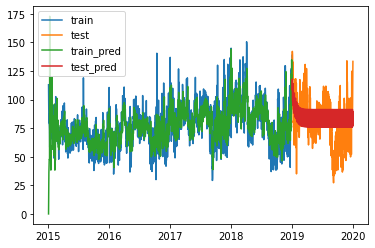

In [68]:
y_hat_train = sari_mod.predict()
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

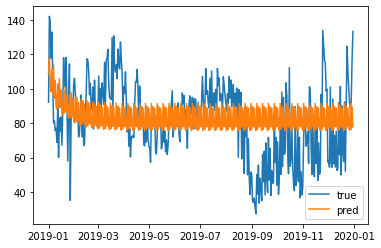

In [71]:
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [72]:
np.sqrt(mean_squared_error(test, y_hat_test))


20.917577338704817

In [ ]:
sari_mod = SARIMAX(df_mk_7dwarfs_daily,
                  order=(4, 0, 1),
                  seasonal_order=(4, 0, 1, 365),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

#### Forecast

In [ ]:
forecast = sari_mod.forecast(steps=365)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df_mk_7dwarfs_daily, label='actual')
ax.plot(forecast, label='forecast')
ax.set_title('7 Dwarfs Mine Train Predictions')

plt.legend();

## Pirates of the Caribbean

In [67]:
df_mk_pirates = pd.read_csv("data/pirates_of_caribbean.csv")
df_mk_pirates

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 08:27:58,NaN,-999.0
1,01/01/2015,2015-01-01 08:56:55,NaN,-999.0
2,01/01/2015,2015-01-01 08:57:38,NaN,-999.0
3,01/01/2015,2015-01-01 08:58:34,NaN,-999.0
4,01/01/2015,2015-01-01 09:24:55,NaN,-999.0
...,...,...,...,...
301941,12/28/2021,2021-12-28 22:35:34,NaN,5.0
301942,12/28/2021,2021-12-28 22:42:15,NaN,5.0
301943,12/28/2021,2021-12-28 22:48:12,NaN,5.0
301944,12/28/2021,2021-12-28 22:54:10,NaN,5.0


In [68]:
CleanNegatives(df_mk_pirates,'SPOSTMIN','SPOSTMINClean')
print(df_mk_pirates)

KeyError: -1

In [ ]:
df_mk_pirates['datetime'] = pd.to_datetime(df_mk_pirates.datetime)
df_mk_pirates.set_index('datetime', inplace=True)
df_mk_pirates = df_mk_pirates['SPOSTMIN']
df_mk_pirates

In [ ]:
df_mk_pirates.isna().sum()

In [ ]:
df_mk_pirates = df_mk_pirates.dropna()

In [ ]:
df_mk_pirates_daily = df_mk_pirates.resample('D').mean()

In [ ]:
df_mk_pirates_daily.plot(figsize=(15,8))

### Splash Mountain

In [ ]:
df_mk_splash = pd.read_csv("data/splash_mountain.csv")
df_mk_splash

#### Cleaning up -999 values

In [ ]:
CleanNegatives(df_mk_splash,'SPOSTMIN','SPOSTMINClean')
print(df_mk_splash)

#### Merging Columns

In [ ]:
Cleanup(df_mk_splash,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_mk_splash)

In [ ]:
df_mk_splash[df_mk_splash.CleanTime < 0]

In [ ]:
df_mk_splash['datetime'] = pd.to_datetime(df_mk_splash.datetime)
df_mk_splash.set_index('datetime', inplace=True)
df_mk_splash = df_mk_splash['SPOSTMIN']
df_mk_splash

In [ ]:
df_mk_splash.isna().sum()

In [ ]:
df_mk_splash = df_mk_splash.dropna()

In [ ]:
df_mk_splash.isna().sum()

In [ ]:
df_mk_splash_daily = df_mk_splash.resample('D').mean()

In [ ]:
df_mk_splash_daily.plot(figsize=(15,8))

In [ ]:
df_mk_splash_daily = df_mk_splash_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_mk_splash_daily = df_mk_splash_daily.ffill()

In [ ]:
df_mk_splash_daily.isna().sum()

In [ ]:
df_mk_splash_daily.plot()

In [ ]:
pvalue = adfuller(df_mk_7dwarfs_daily)[1]
is_stationary = pvalue<= .05

is_stationary

## ANIMAL KINGDOM

### Dinosaur Ride

In [ ]:
df_ak_dinosaur = pd.read_csv("data/dinosaur.csv")
df_ak_dinosaur

In [ ]:
df_ak_dinosaur= df_ak_dinosaur[df_ak_dinosaur.SPOSTMIN != -999]
df_ak_dinosaur

In [ ]:
df_ak_dinosaur['datetime'] = pd.to_datetime(df_ak_dinosaur.datetime)
df_ak_dinosaur.set_index('datetime', inplace=True)
df_ak_dinosaur = df_ak_dinosaur['SPOSTMIN']
df_ak_dinosaur

In [ ]:
df_ak_dinosaur = df_ak_dinosaur.dropna()

In [ ]:
df_ak_dinosaur.isna().sum()

In [ ]:
df_ak_dinosaur_daily = df_ak_dinosaur.resample('D').mean()

In [ ]:
df_ak_dinosaur_daily.plot(figsize=(15,8))

### Expedition Everest

In [ ]:
df_ak_everest =pd.read_csv("data/expedition_everest.csv")
df_ak_everest

In [ ]:
df_ak_everest = df_ak_everest[df_ak_everest.SPOSTMIN != -999]
df_ak_everest

In [ ]:
df_ak_everest['datetime'] = pd.to_datetime(df_ak_everest.datetime)
df_ak_everest.set_index('datetime', inplace=True)
df_ak_everest = df_ak_everest['SPOSTMIN']
df_ak_everest

In [ ]:
df_ak_everest = df_ak_everest.dropna()

In [ ]:
df_ak_everest.isna().sum()

In [ ]:
df_ak_everest_daily = df_ak_everest.resample('D').mean()

In [ ]:
df_ak_everest_daily.plot(figsize=(15,8))

### Kilimajaro Safaris

In [ ]:
df_ak_safari =pd.read_csv("data/kilimanjaro_safaris.csv")
df_ak_safari

In [ ]:
df_ak_safari = df_ak_safari[df_ak_safari.SPOSTMIN != -999]
df_ak_safari

In [ ]:
df_ak_safari['datetime'] = pd.to_datetime(df_ak_safari.datetime)
df_ak_safari.set_index('datetime', inplace=True)
df_ak_safari = df_ak_safari['SPOSTMIN']
df_ak_safari

In [ ]:
df_ak_safari = df_ak_safari.dropna()

In [ ]:
df_ak_safari.isna().sum()

In [ ]:
df_ak_safari_daily = df_ak_safari.resample('D').mean()

In [ ]:
df_ak_safari_daily.plot(figsize=(15,8))

### Navi River

In [ ]:
df_ak_naviriver = pd.read_csv("data/navi_river.csv")
df_ak_naviriver

In [ ]:
df_ak_naviriver = df_ak_naviriver[df_ak_naviriver.SPOSTMIN != -999]
df_ak_naviriver

In [ ]:
df_ak_naviriver['datetime'] = pd.to_datetime(df_ak_naviriver.datetime)
df_ak_naviriver.set_index('datetime', inplace=True)
df_ak_naviriver = df_ak_naviriver['SPOSTMIN']
df_ak_naviriver

In [ ]:
df_ak_naviriver = df_ak_naviriver.dropna()

In [ ]:
df_ak_naviriver.isna().sum()

In [ ]:
df_ak_naviriver_daily = df_ak_naviriver.resample('D').mean()

In [ ]:
df_ak_naviriver_daily.plot(figsize=(15,8))

## EPCOT

### Soarin

In [ ]:
df_ec_soarin = pd.read_csv("data/soarin.csv")
df_ec_soarin

In [ ]:
df_ec_soarin = df_ec_soarin[df_ec_soarin.SPOSTMIN != -999]
df_ec_soarin

In [ ]:
df_ec_soarin['datetime'] = pd.to_datetime(df_ec_soarin.datetime)
df_ec_soarin.set_index('datetime', inplace=True)
df_ec_soarin = df_ec_soarin['SPOSTMIN']
df_ec_soarin

In [ ]:
df_ec_soarin.dropna()

In [ ]:
df_ec_soarin.isna().sum()

In [ ]:
df_ec_soarin_daily = df_ec_soarin.resample('D').mean()

In [ ]:
df_ec_soarin_daily.plot(figsize=(15,8))

### Spaceship Earth

In [ ]:
df_ec_spaceship = pd.read_csv("data/spaceship_earth.csv")
df_ec_spaceship

In [ ]:
df_ec_spaceship = df_ec_spaceship[df_ec_spaceship.SPOSTMIN != -999]
df_ec_spaceship

In [ ]:
df_ec_spaceship['datetime'] = pd.to_datetime(df_ec_spaceship.datetime)
df_ec_spaceship.set_index('datetime', inplace=True)
df_ec_spaceship = df_ec_spaceship['SPOSTMIN']
df_ec_spaceship

In [ ]:
df_ec_spaceship = df_ec_spaceship.dropna()

In [ ]:
df_ec_spaceship.isna().sum()

In [ ]:
df_ec_spaceship_daily = df_ec_spaceship.resample('D').mean()

In [ ]:
df_ec_spaceship_daily.plot(figsize=(15,8))

## HOLLYWOOD STUDIOS

### Slinky Dog Ride

In [ ]:
df_hs_slinky = pd.read_csv("data/slinky_dog.csv")
df_hs_slinky

In [ ]:
df_hs_slinky = df_hs_slinky[df_hs_slinky.SPOSTMIN != -999]
df_hs_slinky

In [ ]:
df_hs_slinky['datetime'] = pd.to_datetime(df_hs_slinky.datetime)
df_hs_slinky.set_index('datetime', inplace=True)
df_hs_slinky = df_hs_slinky['SPOSTMIN']
df_hs_slinky

In [ ]:
df_hs_slinky = df_hs_slinky.dropna()

In [ ]:
df_hs_slinky.isna().sum()

In [ ]:
df_hs_slinky_daily = df_hs_slinky.resample('D').mean()

In [ ]:
df_hs_slinky_daily.plot(figsize=(15,8))

### Toy Story

In [ ]:
df_hs_toystory = pd.read_csv("data/toy_story_mania.csv")
df_hs_toystory

In [ ]:
df_hs_toystory = df_hs_toystory[df_hs_toystory.SPOSTMIN != -999]
df_hs_toystory

In [ ]:
df_hs_toystory['datetime'] = pd.to_datetime(df_hs_toystory.datetime)
df_hs_toystory.set_index('datetime', inplace=True)
df_hs_toystory = df_hs_toystory['SPOSTMIN']
df_hs_toystory

In [ ]:
df_hs_toystory = df_hs_toystory.dropna()

In [ ]:
df_hs_toystory.isna().sum()

In [ ]:
df_hs_toystory_daily = df_hs_toystory.resample('D').mean()

In [ ]:
df_hs_toystory_daily.plot(figsize=(15,8))

### Rock -n- Roller Coaster

In [ ]:
df_hs_rockin = pd.read_csv('data/rock_n_rollercoaster.csv')
df_hs_rockin 

In [ ]:
df_hs_rockin = df_hs_rockin [df_hs_rockin.SPOSTMIN != -999]
df_hs_rockin 

In [ ]:
df_hs_rockin['datetime'] = pd.to_datetime(df_hs_rockin.datetime)
df_hs_rockin.set_index('datetime', inplace=True)
df_hs_rockin = df_hs_rockin['SPOSTMIN']
df_hs_rockin

In [ ]:
df_hs_rockin = df_hs_rockin.dropna()

In [ ]:
df_hs_rockin.isna().sum()

In [ ]:
df_hs_rockin_daily = df_hs_rockin.resample('D').mean()

In [ ]:
df_hs_rockin_daily.plot(figsize=(15,8))

### Entities for Rides

In [ ]:
df_entities = pd.read_csv("data/entities.csv")    
df_entities

### Medadata

In [ ]:
df_metadata = pd.read_csv("data/metadata.csv")
df_metadata